In [15]:
from datetime import datetime
import serial
import serial.tools.list_ports
import platform
import numpy as np
import csv
import matplotlib.pyplot as plt
plt.style.use('dark_background')

Generic Functions, which we might find useful.

In [16]:
def printLog(*args, **kwargs):
    stamp = str(datetime.now())
    print("[" + stamp + "]", *args)

def errorLog(*args, **kwargs):
    stamp = str(datetime.now())
    print("[" + stamp + "]", *args)

def listPorts():
    devOS = platform.system()
    printLog("Detected", devOS, "Computer")
    ports = []
    if devOS == "Windows":
        ports = serial.tools.list_ports.comports()
    printLog("Listing all Serial Ports:")
    for p in ports:
        printLog(p)

def setupSerial():
    listPorts()
    while True:
        try:
            port = input("enter port:")
            s = serial.Serial(port)
            s.baudrate = 115200
            s.bytesize = serial.EIGHTBITS
            s.parity = serial.PARITY_NONE
            s.stopbits = serial.STOPBITS_ONE
            printLog("Serial Port open on", port.upper(), "for EFR32BG22")
            return s
        except serial.SerialException:
            errorLog("Invalid Serial Port, please try again!")
            continue

Read data from the Serial Port

In [77]:
ser = setupSerial()

[2020-08-07 12:45:41.849477] Detected Windows Computer
[2020-08-07 12:45:41.930292] Listing all Serial Ports:
[2020-08-07 12:45:41.930292] COM1 - Communications Port (COM1)
[2020-08-07 12:45:41.930292] COM9 - JLink CDC UART Port (COM9)


enter port: com9


[2020-08-07 12:45:44.416382] Serial Port open on COM9 for EFR32BG22


In [84]:
samp = 1024
larr = np.zeros(samp)
rarr = np.zeros(samp)

larr_raw = []
rarr_raw = []

while True:
    res = ser.readline().decode().strip()
    if res == "left":
        larr_raw = ser.readline().decode().strip().split(" ") # printLog(larr_raw)
        break
printLog("captured left")
while True:
    res = ser.readline().decode().strip()
    if res == "right":
        rarr_raw = ser.readline().decode().strip().split(" ") # printLog(rarr_raw)
        break
printLog("captured right")
larr = np.array(list(map(int, larr_raw)))
rarr = np.array(list(map(int, rarr_raw)))

[2020-08-07 12:56:51.532333] captured left
[2020-08-07 12:56:51.909609] captured right


Plot the Data

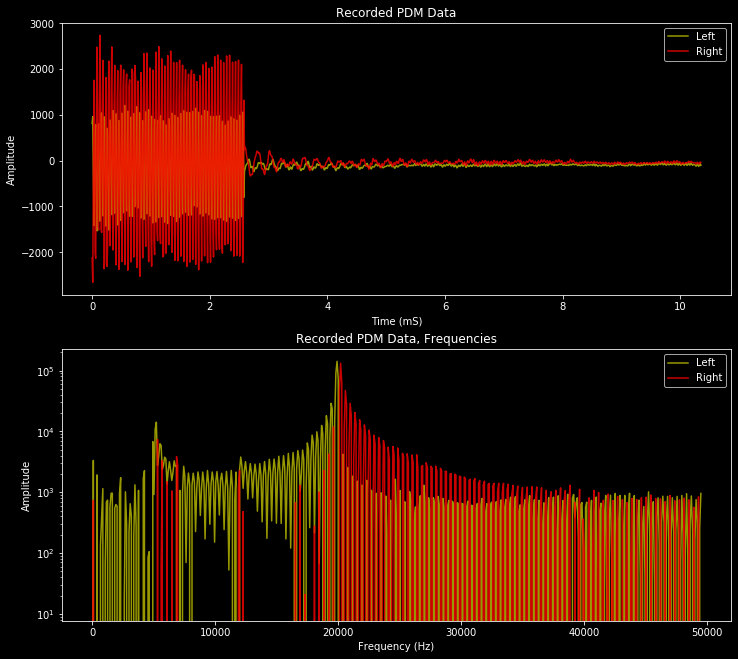

In [85]:
fsamp = 19e6 / 32 / 6
fig, axs = plt.subplots(2, 1, figsize=(12, 11))

time_axs = np.linspace(0, 1000 * samp / fsamp, samp)
axs[0].plot(time_axs, larr, 'y', alpha = 0.8, label = "Left")
axs[0].plot(time_axs, rarr, 'r', alpha = 0.8, label = "Right")
axs[0].set_title("Recorded PDM Data")
axs[0].set_xlabel("Time (mS)")
axs[0].set_ylabel("Amplitude")
axs[0].legend()

fL = np.fft.rfft(larr)
fR = np.fft.rfft(rarr)
freq_axs = np.arange(len(fL))*fsamp/samp

axs[1].semilogy(freq_axs, np.real(fL), 'y', alpha = 0.8, label = "Left")
axs[1].semilogy(freq_axs, np.real(fR), 'r', alpha = 0.8, label = "Right")
axs[1].set_title("Recorded PDM Data, Frequencies")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Amplitude")
axs[1].legend()

plt.show()

In [88]:
ser.close()